# T5 - Junctions

Junctions in Atomica are special compartments that do not hold any people. They are used to reparametrize transitions, taking in input from one or more compartments, and then dividing it into downstream compartments. They are useful in cases where you know the proportions of the flow into a set of compartments.

To examine this in detail, consider a simple modification of the SIR example where there are two strains of the disease - normal, and drug resistant. The compartments and overall structure of the model would be similar to:

![t5-junctions-1](assets/T5/t5_junctions_1.png)

Simply building on our previous model, we could achieve the required functionality by having flows from 'Susceptible' to each of the compartments

![t5-junctions-2](assets/T5/t5_junctions_2.png)

However, what should the probabilities associated with those flows be? Let's assume that we know the proportion of new infections that are drug resistant. The force of infection would need to be multiplied by those proportions to get the probability for each transition - we would need to add parameters for the proportion of people, as well as duplicating the force of infection for each of the links. This adds complexity without being an intuitive way to work with the proportions. Instead, we can use a junction, set up as follows:

![t5-junctions-3](assets/T5/t5_junctions_3.png)

We have a flow out of 'Susceptible' equal to the same force of infection as before, but now going into a junction. The junction has outflows where the parameters correspond to the proportion of people going into each of the infected states. This way, the force of infection doesn't need to be duplicated. It's also a parsimonious way to divide the infections if there is more than one source of infections. For example, if people can be vaccinated and still become infected:

![t5-junctions-4](assets/T5/t5_junctions_4.png)

For a normal compartment, the update rule is

1. First work out how many people are transferred out via each link based on the relevant parameter values, rescaling as required to avoid negative compartment sizes. Only people currently in the compartment are eligible to be transferred out
2. The size of the compartment at the next timestep is equal to the inflows plus the outflows, and is greater than or equal to zero

For junctions, the rule for calculating the junction outflows is slightly different

1. Work out how many people are flowing into the junction
2. Assign the outgoing link values such that their relative proportions match the parameters, and their values sum to the number of people flowing into the compartment in the current timestep
3. The size of the compartment at the next timestep is equal to the inflows plus the outflows. However, since the outflows have been 'balanced' to equal the inflows, the size of the compartment at the next timestep is guaranteed to be zero.

To implement a junction in a framework, we simply implement a compartment structure as usual, but enter 'y' in the 'Is Junction' column for any junctions:

![t5-junctions-f1](assets/T5/t5_junctions_f1.png)

Notice we have assigned a default value to the 'Susceptible' compartment, so that the databook will be pre-filled with that value. This will later allow us to run the model with default values without needing to enter any additional information in the databook.

The transitions are set up in the usual way:

![t5-junctions-f2](assets/T5/t5_junctions_f2.png)

For the parameters, we will set the force of infection to be a fixed number per year, just for this illustrative example.

![t5-junctions-f3](assets/T5/t5_junctions_f3.png)

Importantly, all junction outflows must be in 'proportion' units. Proportions differ from probabilities in that they do not get rescaled with the simulation timestep. Proportion units can thus only be used for transitions out of junctions. Note that we have set `prop_normal` to be `1-prop_dr` so that only the proportion of new infections that are drug-resistant needs to be entered. However, note that junction outflows are automatically rescaled (linearly) so that they sum to `1` - so entering `1` and `2` as the proportions would give the same result as `0.33` and `0.67`. 

We can now proceed to run the model. Because we have entered default values for all of the quantities that appear in the databook, we can create a `ProjectData` object and then immediately use it to create a project, without actually even writing the databook to disk. The framework file is located in `atomica/docs/tutorial/assets/T5/t5_framework1.xlsx`

In [1]:
import atomica as at
F = at.ProjectFramework('assets/T5/t5_framework1.xlsx')
D = at.ProjectData.new(framework=F,tvec=[2016],pops=1,transfers=0)
P = at.Project(framework=F,databook=D.to_spreadsheet())
result = P.results[0]

Elapsed time for running "default": 0.00720s


Let's now plot all of the compartments

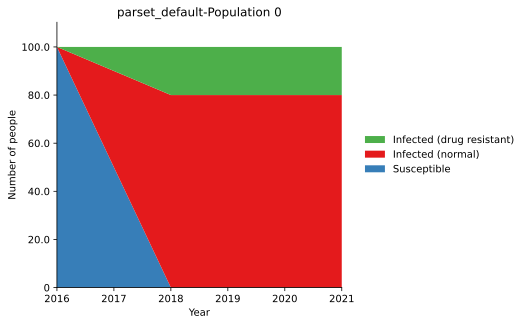

In [2]:
d = at.PlotData(result,outputs=['sus','inf','inf_dr'],project=P)
at.plot_series(d,plot_type='stacked');

We can see how the susceptible compartment is decreasing at a rate of 50 people per year until it is empty, and they are being divided in a `1:5` ratio due to the `prop_dr` being `0.2`, such that at the end, of the original 100 people that were susceptible, 20 of them have drug resistant infections.

## Exercise

1. Add a drug resistant infection state to the SIR framework in Tutorial 1, using the junction structure illustrated above. The databook should contain the proportion of new infections that are drug resistant, as shown here
2. Add a vaccinated state to the model. Vaccinations should be entered in the databook as a number of people per year. Vaccinations move people from susceptible to a vaccinated state. The force of infection should be lower for vaccinated people, and you will need a parameter to store the vaccine efficacy. If the vaccination rate is zero, the simulation will be identical to the one in the first exercise here. Make a plot showing the effect of increasing the vaccination rate (hint: the plotting commands will be essentially the same as how the output from multiple simulations with different parameters is produced in Tutorial 2)  